In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special, interpolate
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV as cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

import powerlaw


plt.rcParams['font.family'] ='sans-serif'#使用するフォント
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0#x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0#y軸主目盛り線の線幅
plt.rcParams['font.size'] = 8 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ

In [2]:
df = pd.read_pickle('../data/df.pickle')

df_lockdown = df[(df["started_at"] >= "2020-03-21") & (df["started_at"] < "2020-06-01")].dropna()
df_20200601_20201116 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-11-17")].dropna()
df_20201117_20201216 = df[(df["started_at"] >= "2020-11-17") & (df["started_at"] < "2020-12-17")].dropna()
df_20201217_20201231 = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2021-01-01")].dropna()
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] < "2022-01-01")].dropna()
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] < "2023-01-01")].dropna()
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] < "2023-10-01")].dropna()
df_2020 = df[(df["started_at"] >= "2020-01-01") & (df["started_at"] < "2021-01-01")].dropna()

In [3]:
def getNetworkAnalysis(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df = df.sort_values(by='start_station_name')

    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []
    distance_list = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # ユニークな駅のリストを取得
        # values.ravel('K')で多次元配列を1次元配列に変換
        unique_stations = pd.unique(df_tmp[['start_station_name', 'end_station_name']].values.ravel('K'))

        # node_listにノード数を追加
        node_list.append(len(unique_stations))

        # edge_listにエッジ数を追加
        df_tmp = df_tmp.drop_duplicates(subset=['start_station_name', 'end_station_name'])
        edge_list.append(len(df_tmp))

        # distance_listに平均距離を追加
        distance_list.append(df_tmp['distance'].mean())

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp, distance_list

In [4]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [10]:
node_lockdown, edge_lockdown, timestamp_lockdown, distance_lockdown = getNetworkAnalysis(df_lockdown)
node_after_lockdown, edge_after_lockdown, timestamp_after_lockdown, distance_after_lockdown = getNetworkAnalysis(df_20200601_20201116)
node_stayhome, edge_stayhome, timestamp_stayhome, distance_stayhome = getNetworkAnalysis(df_20201117_20201216)
node_after_stayhome, edge_after_stayhome, timestamp_after_stayhome, distance_after_stayhome = getNetworkAnalysis(df_20201217_20201231)
node_2021, edge_2021, timestamp_2021, distance_2021 = getNetworkAnalysis(df_2021)
node_2022, edge_2022, timestamp_2022, distance_2022 = getNetworkAnalysis(df_2022)
node_2023, edge_2023, timestamp_2023, distance_2023 = getNetworkAnalysis(df_2023)
node_2020, edge_2020, timestamp_2020, distance_2020 = getNetworkAnalysis(df_2020)

In [11]:
kappa_lockdown = []
kappa_20200601_20201116 = []
kappa_20201117_20201216 = []
kappa_20201217_20201231 = []
kappa_2020 = []
kappa_2021 = []
kappa_2022 = []
kappa_2023 = []

In [12]:
alpha_lockdown, beta_lockdown = 0.086, 1.257
alpha_after_lockdown, beta_after_lockdown = 0.085, 5.735
alpha_stayhome, beta_stayhome = 0.085, 1.626
alpha_after_stayhome, beta_after_stayhome = 0.094, 3.621
alpha_2020, beta_2020 = 0.075, 0.795 
alpha_2021, beta_2021 = 0.087, 2.238
alpha_2022, beta_2022 = 0.118, 8.603
alpha_2023, beta_2023 = 0.119, 7.9

Np = 1652

In [13]:
kappa_lockdown = []
for i in range(len(edge_lockdown)):
    alpha, beta = alpha_lockdown, beta_lockdown
    kappa_lockdown.append(kappa(edge_lockdown[i], Np))

In [14]:
kappa_after_lockdown = []
for i in range(len(edge_after_lockdown)):
    alpha, beta = alpha_after_lockdown, beta_after_lockdown
    kappa_after_lockdown.append(kappa(edge_after_lockdown[i], Np))

In [15]:
kappa_stayhome = []
for i in range(len(edge_stayhome)):
    alpha, beta = alpha_stayhome, beta_stayhome
    kappa_stayhome.append(kappa(edge_stayhome[i], Np))

In [16]:
kappa_after_stayhome = []
for i in range(len(edge_after_stayhome)):
    alpha, beta = alpha_after_stayhome, beta_after_stayhome
    kappa_after_stayhome.append(kappa(edge_after_stayhome[i], Np))

In [17]:
kappa_2020 = []
for i in range(len(edge_2020)):
    alpha, beta = alpha_2020, beta_2020
    kappa_2020.append(kappa(edge_2020[i], Np=Np))

In [18]:
kappa_2021 = []
for i in range(len(edge_2021)):
    alpha, beta = alpha_2021, beta_2021
    kappa_2021.append(kappa(edge_2021[i],Np=Np))

In [19]:
kappa_2022 = []
for i in range(len(edge_2022)):
    alpha, beta = alpha_2022, beta_2022
    kappa_2022.append(kappa(edge_2022[i],Np=Np))

In [20]:
kappa_2023 = []
for i in range(len(edge_2023)):
    alpha, beta = alpha_2023, beta_2023
    kappa_2023.append(kappa(edge_2023[i],Np=Np))

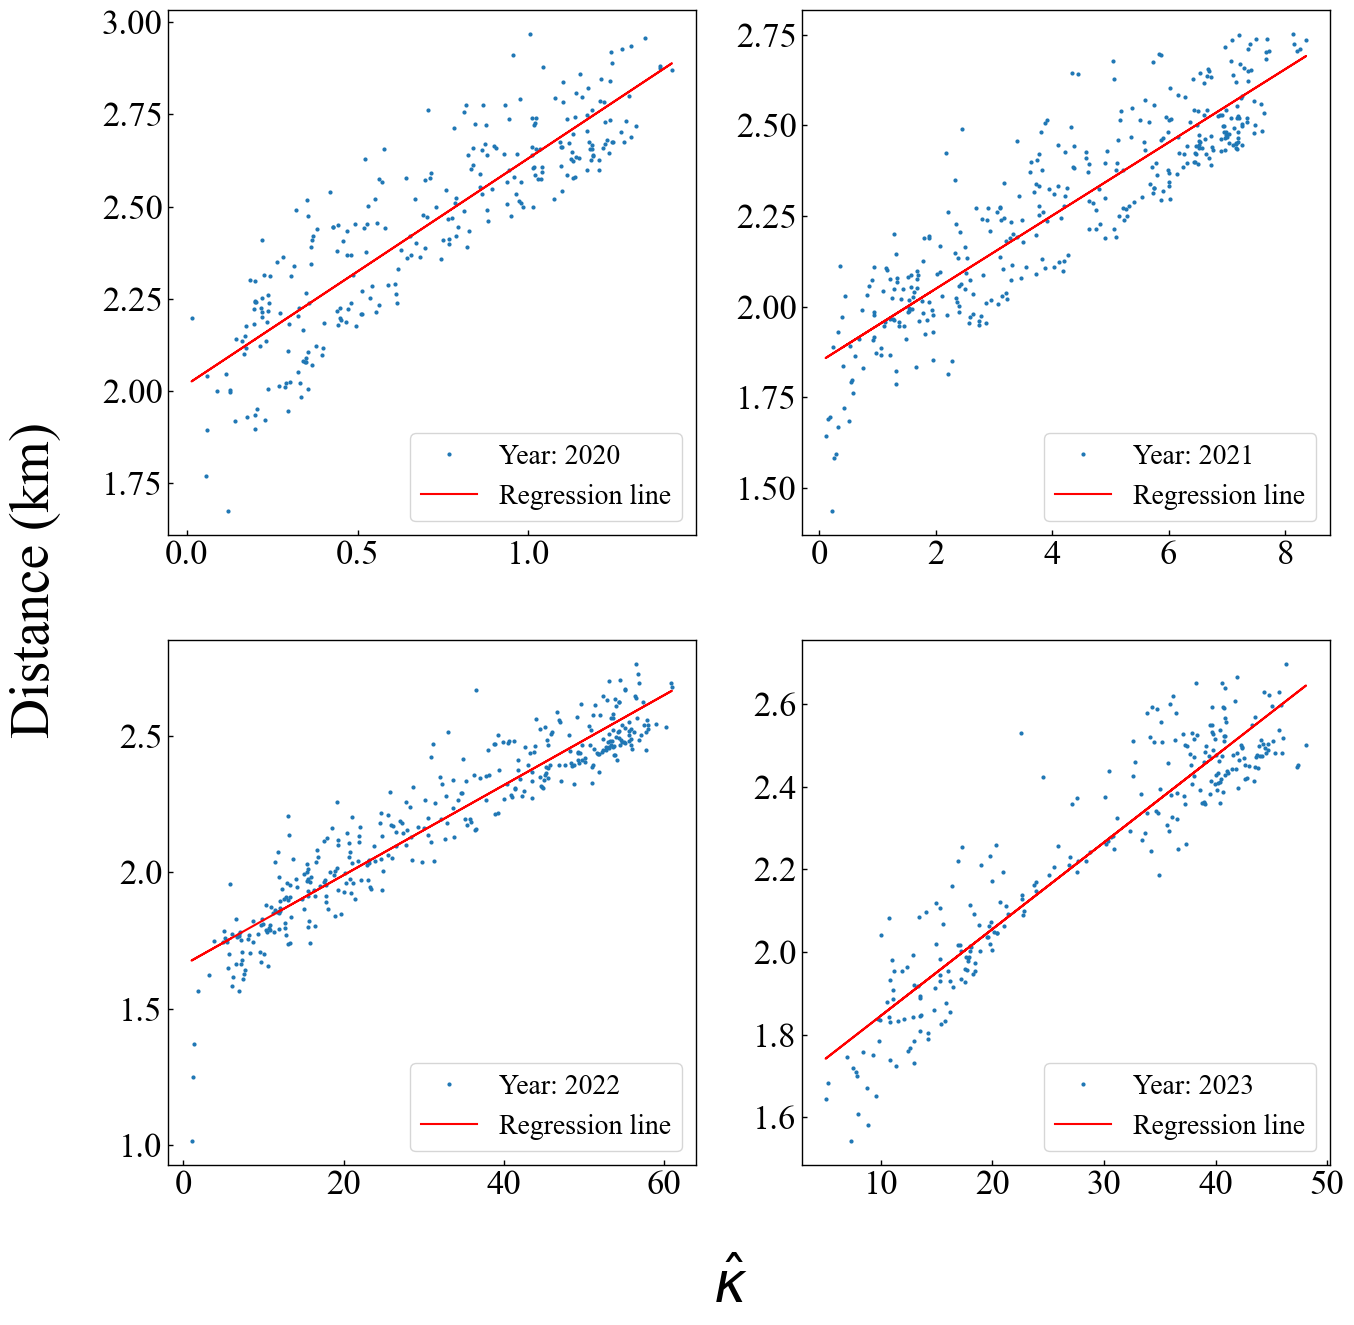

In [64]:
# 2021年のkappaと距離の関係
# olsを用いて回帰分析を行う
# plt.figure(figsize=(10, 10))

# fontをtimes new romanに変更
plt.rcParams['font.family'] = 'Times New Roman'
# 軸らベルのフォントサイズを設定
plt.rcParams['axes.labelsize'] = 20

kappa_distance_2020_df = pd.DataFrame({"kappa": kappa_2020, "distance": distance_2020})
kappa_distance_2020_df = kappa_distance_2020_df.dropna()
model = smf.ols("distance ~ kappa", data=kappa_distance_2020_df)
result = model.fit()

kappa_distance_2021_df = pd.DataFrame({"kappa": kappa_2021, "distance": distance_2021})
model2 = smf.ols("distance ~ kappa", data=kappa_distance_2021_df)
result2 = model2.fit()

kappa_distance_2022_df = pd.DataFrame({"kappa": kappa_2022, "distance": distance_2022})
kappa_distance_2022_df = kappa_distance_2022_df[kappa_distance_2022_df["distance"] < 10]
model3 = smf.ols("distance ~ kappa", data=kappa_distance_2022_df)
result3 = model3.fit()

kappa_distance_2023_df = pd.DataFrame({"kappa": kappa_2023, "distance": distance_2023})
kappa_distance_2023_df = kappa_distance_2023_df[kappa_distance_2023_df["distance"] < 3]
model4 = smf.ols("distance ~ kappa", data=kappa_distance_2023_df)
result4 = model4.fit()

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)

ax1.plot(kappa_distance_2020_df["kappa"], kappa_distance_2020_df["distance"], "o", markersize=2, label="Year: 2020")
ax1.plot(kappa_distance_2020_df["kappa"], result.fittedvalues, color="red", label="Regression line")
ax1.legend(prop={"size": 20})
# ラベルのフォントサイズを設定
# ax1.set_xlabel(r"$\hat{\kappa}$", fontsize=20)
# ax1.set_ylabel("Distance (km)", fontsize=20)
# 軸のメモリのフォントサイズを設定
ax1.tick_params(labelsize=25)

ax2.plot(kappa_distance_2021_df["kappa"], kappa_distance_2021_df["distance"], "o", markersize=2, label="Year: 2021")
ax2.plot(kappa_distance_2021_df["kappa"], result2.fittedvalues, color="red", label="Regression line")
ax2.legend(prop={"size": 20})
# ラベルのフォントサイズを設定
# ax2.set_xlabel(r"$\hat{\kappa}$", fontsize=20)
# ax2.set_ylabel("Distance (km)", fontsize=20)
# 軸のメモリのフォントサイズを設定
ax2.tick_params(labelsize=25)

ax3.plot(kappa_distance_2022_df["kappa"], kappa_distance_2022_df["distance"], "o", markersize=2, label="Year: 2022")
ax3.plot(kappa_distance_2022_df["kappa"], result3.fittedvalues, color="red", label="Regression line")
ax3.legend(prop={"size": 20})
# ラベルのフォントサイズを設定
# ax3.set_xlabel(r"$\hat{\kappa}$", fontsize=20)
# ax3.set_ylabel("Distance (km)", fontsize=20)
# 軸のメモリのフォントサイズを設定
ax3.tick_params(labelsize=25)

ax4.plot(kappa_distance_2023_df["kappa"], kappa_distance_2023_df["distance"], "o", markersize=2, label="Year: 2023")
ax4.plot(kappa_distance_2023_df["kappa"], result4.fittedvalues, color="red", label="Regression line")
ax4.legend(prop={"size": 20})
# ラベルのフォントサイズを設定
# ax4.set_xlabel(r"$\hat{\kappa}$", fontsize=20)
# ax4.set_ylabel("Distance (km)", fontsize=20)
# 軸のメモリのフォントサイズを設定
ax4.tick_params(labelsize=25)

fig.supxlabel(r"$\hat{\kappa}$", fontsize=40)
fig.supylabel("Distance (km)", fontsize=40)

"""
plt.xlabel(r"$\hat{\kappa}$")
plt.ylabel("Distance (km)")
#plt.tick_params(labelsize=40)
plt.legend(prop={"size": 8})
"""
plt.savefig("../fig/cssj/kappa_distance_v2.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()


In [35]:
print(result.fittedvalues)

0      2.138421
1      2.149983
2      2.190479
3      2.130189
4      2.152162
         ...   
270    2.161787
271    2.183336
272    2.140237
273    2.104524
274    2.139027
Length: 273, dtype: float64
